In [1]:
import math
import os

import wandb
from sage.config import (
    DataArguments,
    MiscArguments,
    ModelArguments,
    TrainingArguments,
    argument_parser,
    get_logger,
    logger_conf,
)
from sage.data import get_dataloader
from sage.models import build_model
from sage.training.trainer import MRITrainer
from sage.utils import seed_everything, set_path

model_args, data_args, training_args, misc_args = (
    ModelArguments,
    DataArguments,
    TrainingArguments,
    MiscArguments,
)

# Fixate Seed
seed_everything(misc_args.seed)

# Set GPU device
if misc_args.which_gpu != -1:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(misc_args.which_gpu)

# Set saving path
misc_args.output_dir, run_name = set_path(
    model_args, data_args, training_args, misc_args
)

# Set logger configuration. Change logger file to "/run.log"
logger_conf["handlers"]["file_handler"]["filename"] = misc_args.output_dir + "/run.log"
logger = get_logger(logger_conf)

# Build dataloaders
train_dataloader = get_dataloader(data_args, misc_args, "train", logger)
if training_args.scheduler in ["linear_warmup", "cosine_linear_warmup"]:
    training_args.total_steps = int(
        math.ceil(len(train_dataloader.dataset) / data_args.batch_size)
    ) * (training_args.epochs)
    training_args.warmup_steps = training_args.total_steps // 10
valid_dataloader = get_dataloader(data_args, misc_args, "valid", logger)
test_dataloader = get_dataloader(data_args, misc_args, "test", logger)

/opt/conda/envs/research/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No errors found in setting path.
2022-05-07 16:41:46,019 - root - INFO - Initialize dataset.
2022-05-07 16:41:46,035 - root - INFO - Successfully setup 1044 brains for Train
2022-05-07 16:41:46,036 - root - INFO - Initialize dataset.
2022-05-07 16:41:46,053 - root - INFO - Successfully setup 262 brains for Valid
2022-05-07 16:41:46,054 - root - INFO - Initialize dataset.
2022-05-07 16:41:46,069 - root - INFO - Successfully setup 146 brains for Test


In [13]:
import nibabel
import nilearn.plotting as nplot
import numpy as np
import torchio as tio

In [65]:
transform_dict = {
    "identity": tio.Lambda(lambda x: x),
    "flip": tio.RandomFlip(axes=["left-right"]),
    "affine": tio.RandomAffine(),
    "elastic_deformation": tio.RandomElasticDeformation(),
    "gamma": tio.RandomGamma((-1, 1)),
    "bias": tio.RandomBiasField(0.3),
    "blur": tio.RandomBlur((0, 1)),
}

to_nifti = lambda arr: nibabel.nifti1.Nifti1Image(arr, affine=np.eye(4))
brain_batch = next(iter(valid_dataloader))[0]

In [66]:
import matplotlib.pyplot as plt


def plot_transformation(transform, name, batch=brain_batch):

    print(f"Transformation: {name.capitalize()}")

    cut_coords = (48, 48, 48)
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 20))
    for i in range(3):

        brain = batch[i]
        scan = to_nifti(brain[0].numpy())
        nplot.plot_anat(scan, axes=ax[i][0], cut_coords=cut_coords)

        transformed_brain = transform(brain)
        scan = to_nifti(transformed_brain[0].numpy())
        nplot.plot_anat(scan, axes=ax[i][1], cut_coords=cut_coords)

Transformation: Flip


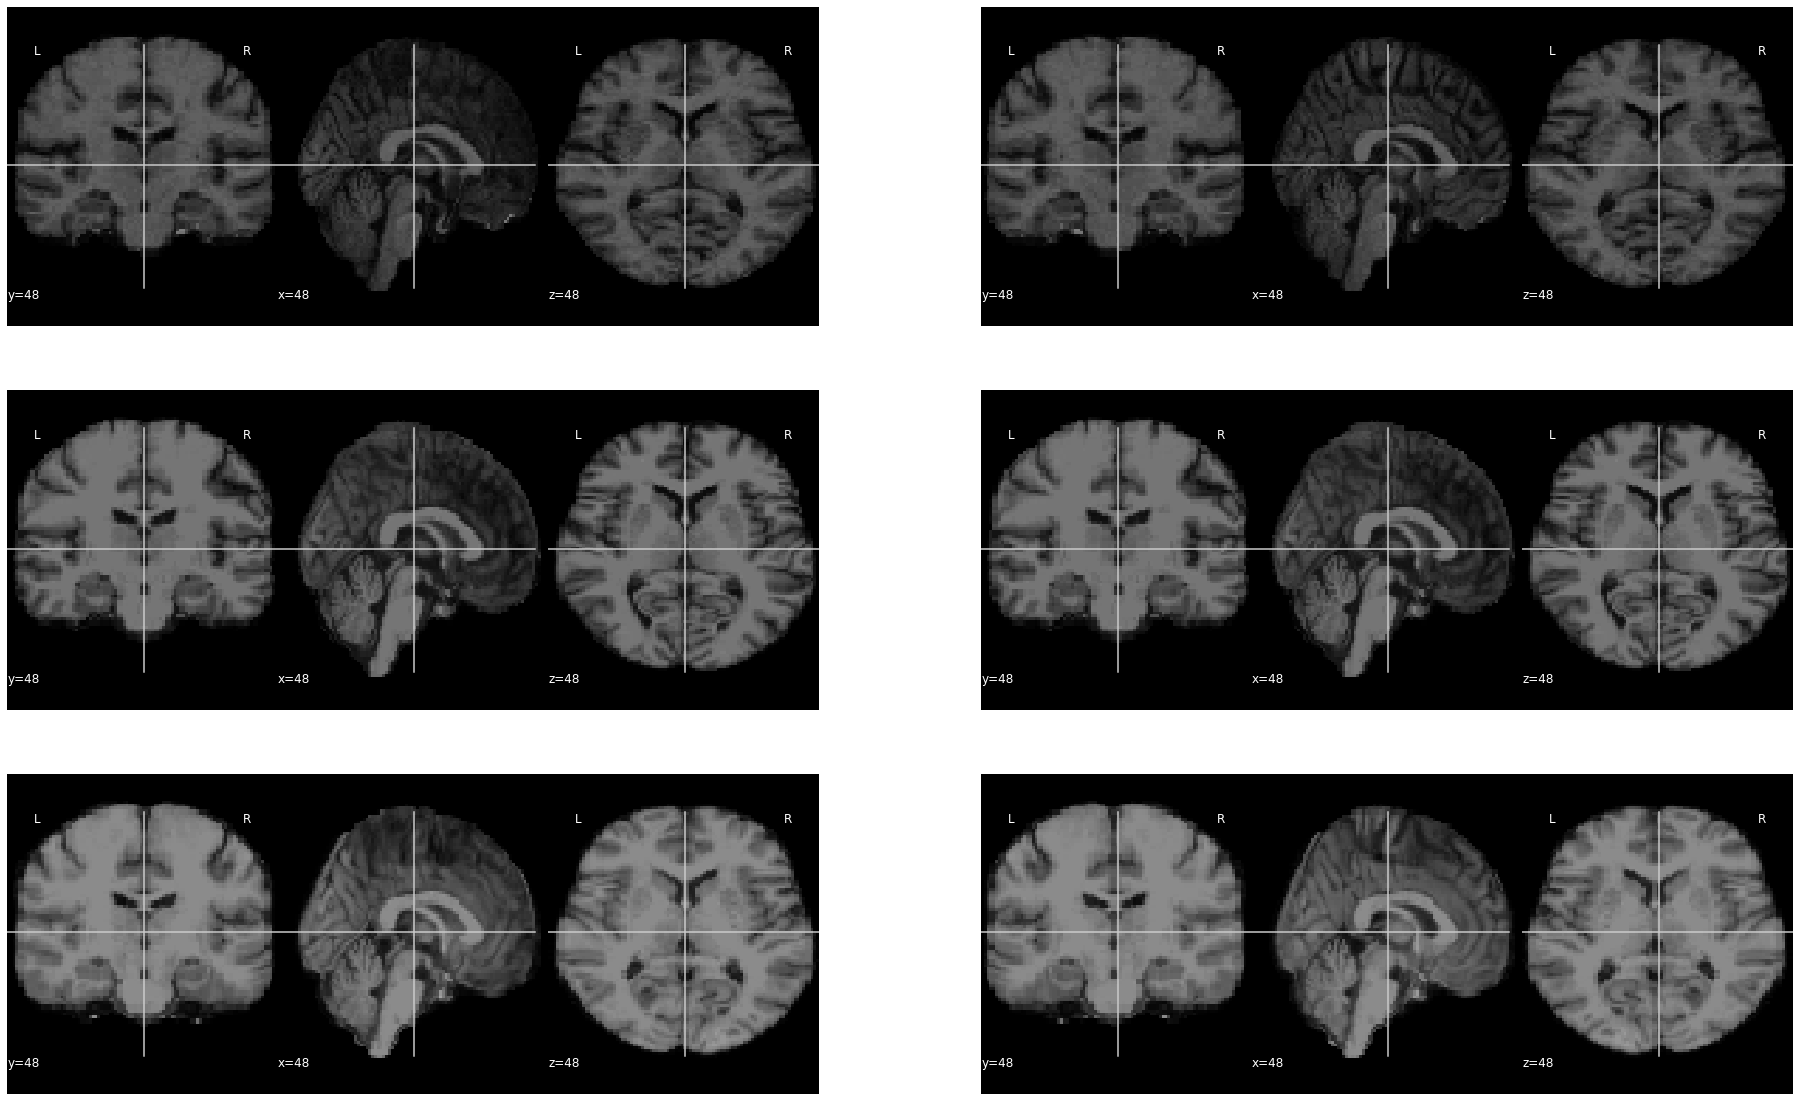

In [67]:
t = "flip"
plot_transformation(transform_dict[t], t)

Transformation: Affine


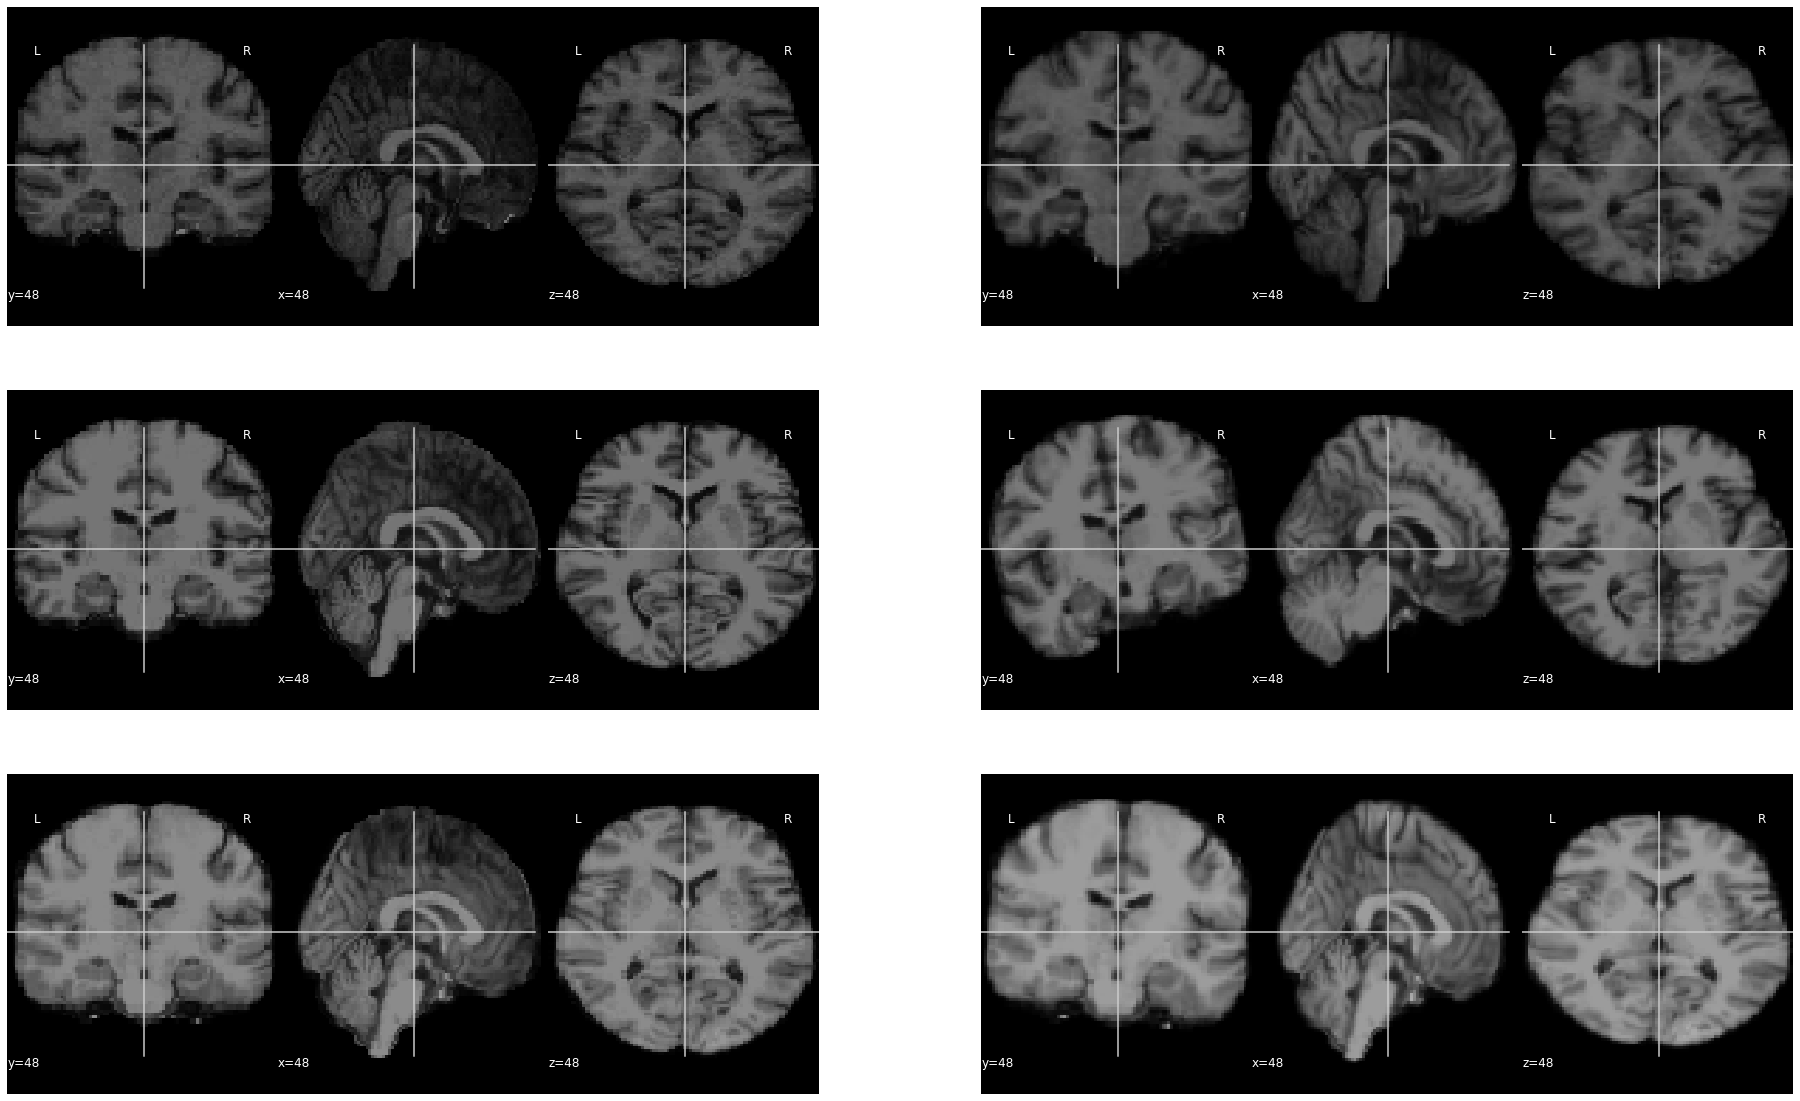

In [68]:
t = "affine"
plot_transformation(transform_dict[t], t)

Transformation: Elastic_deformation


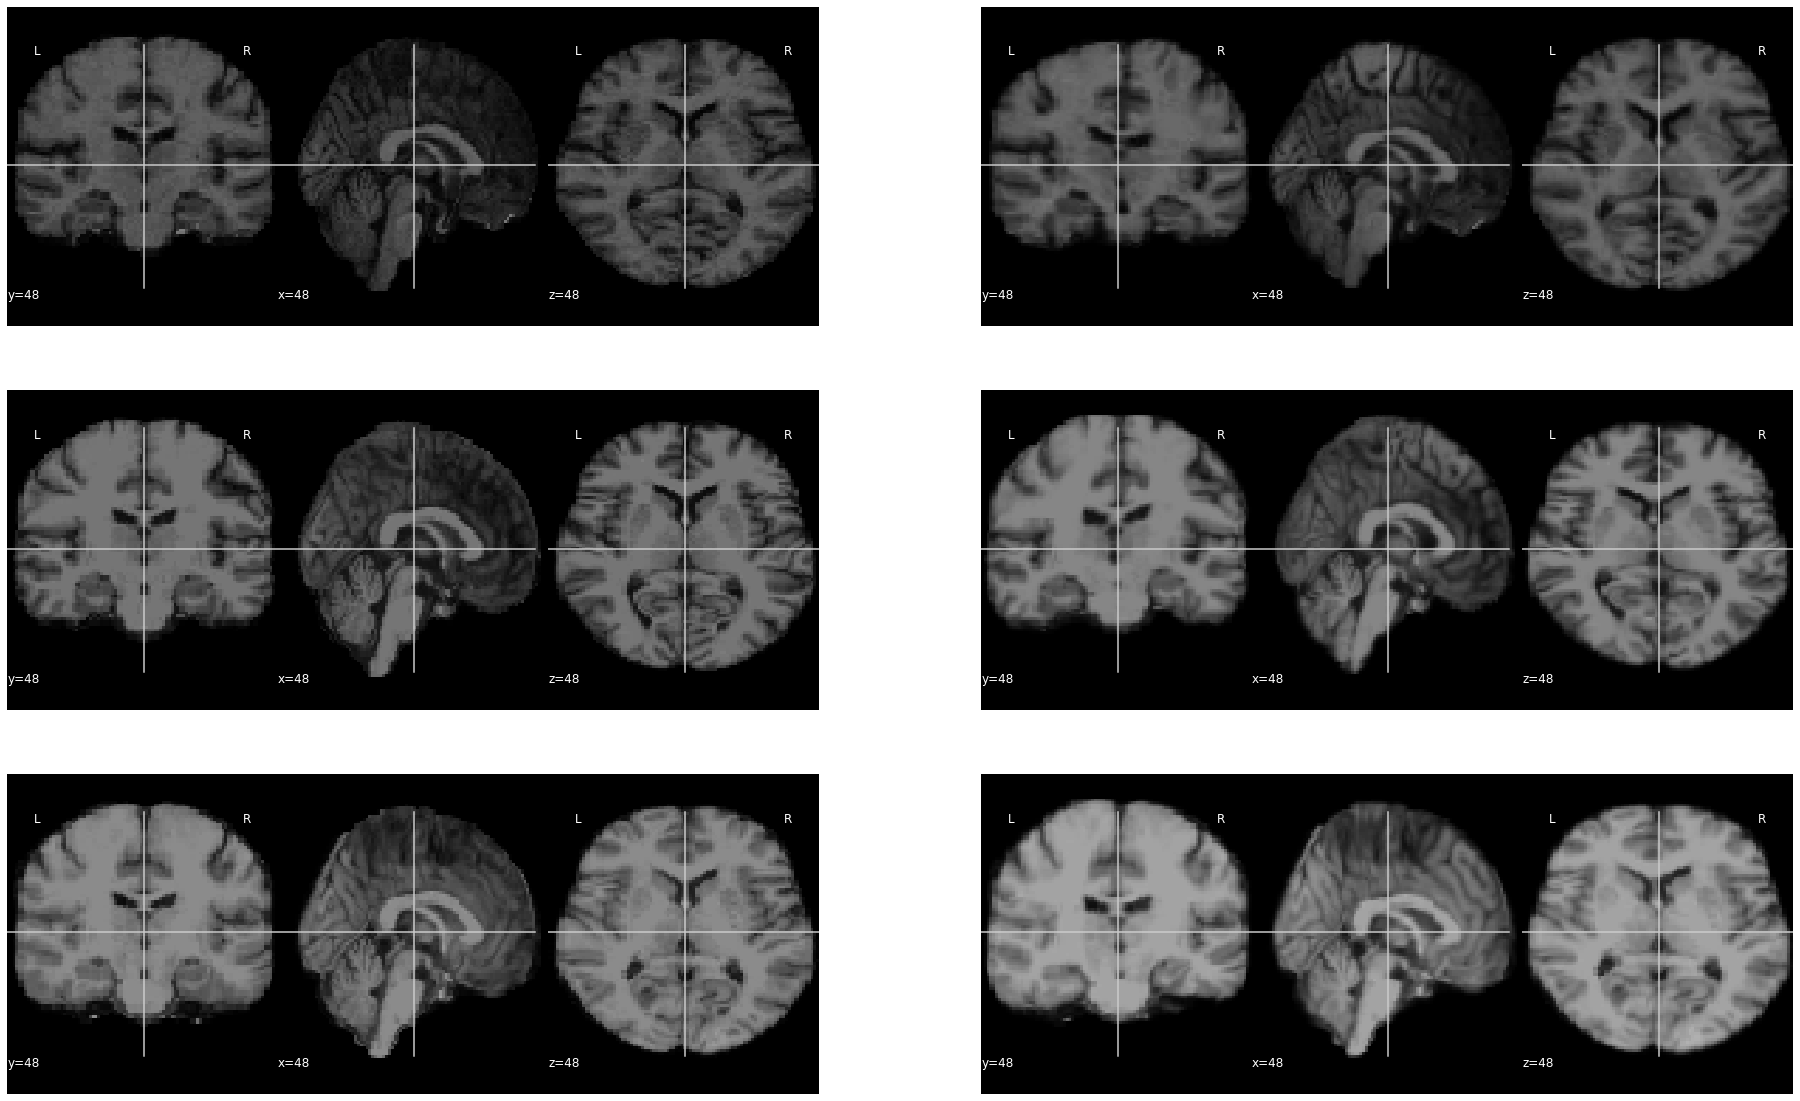

In [69]:
t = "elastic_deformation"
plot_transformation(transform_dict[t], t)

Transformation: Gamma


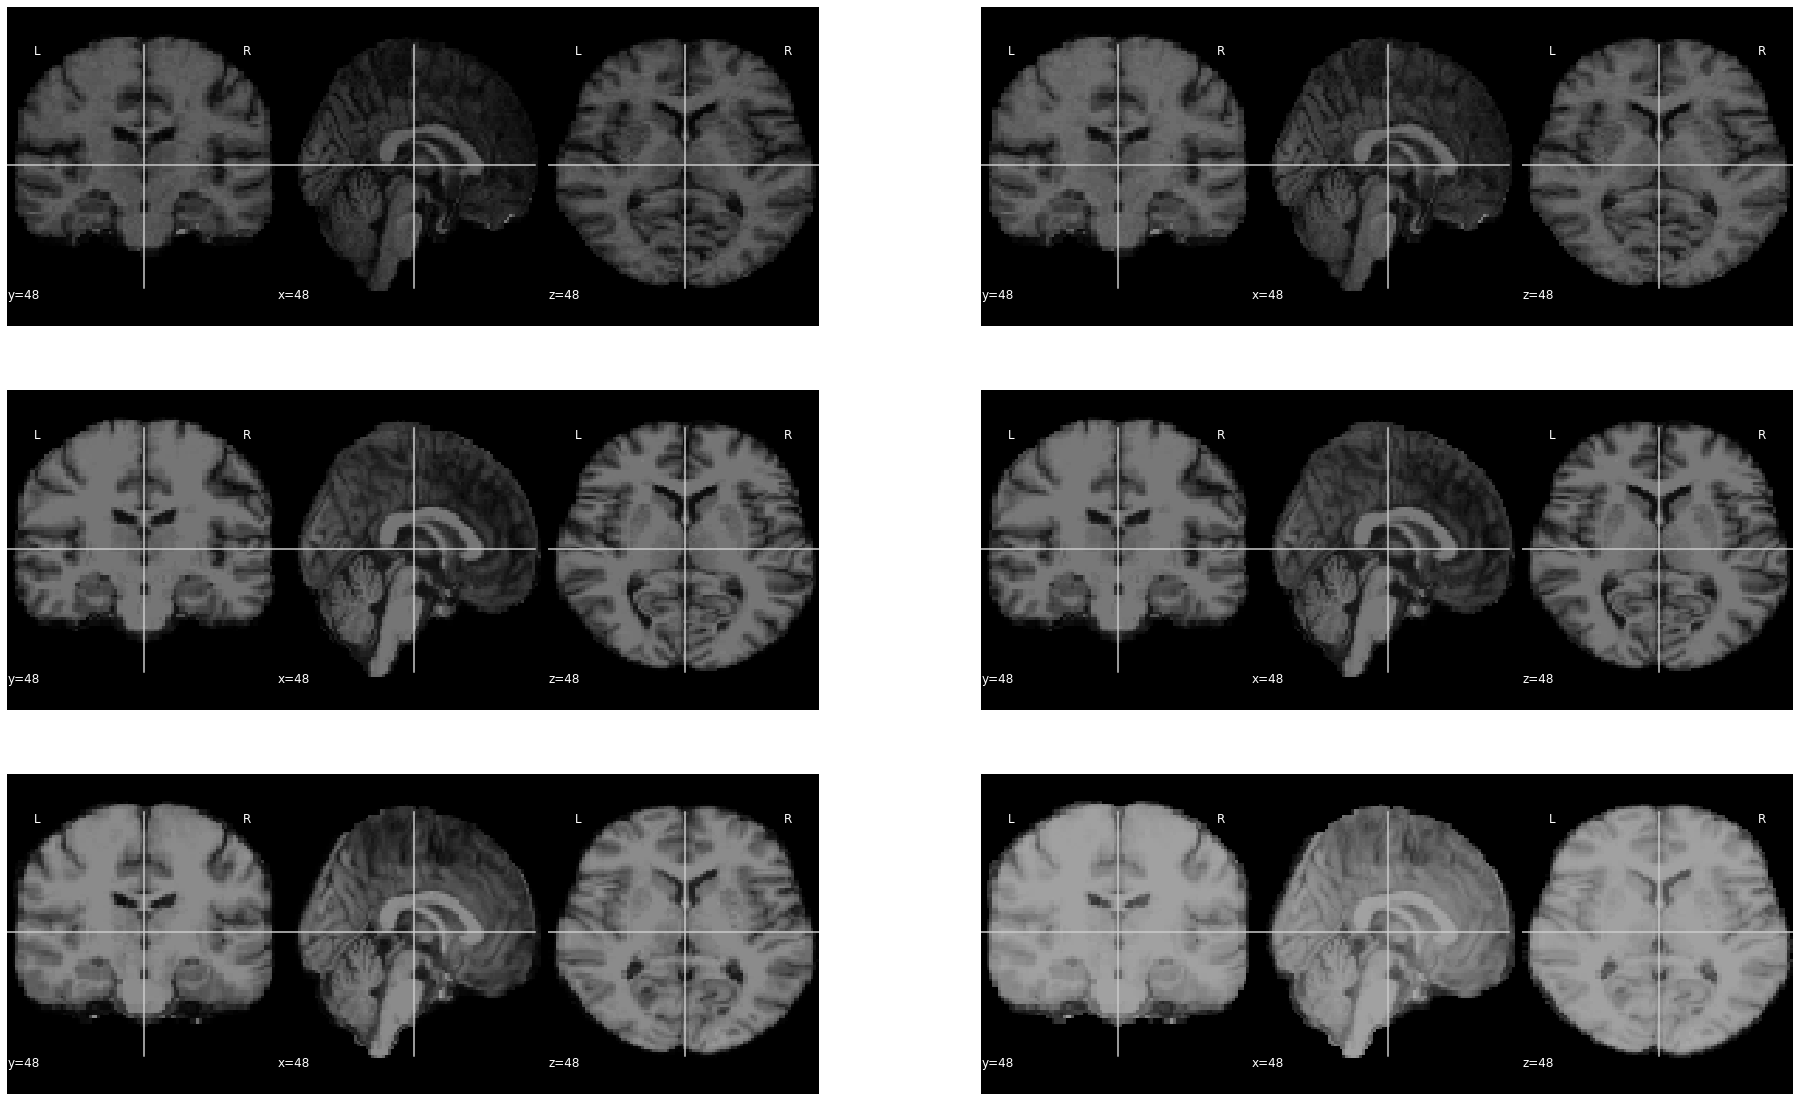

In [70]:
t = "gamma"
plot_transformation(transform_dict[t], t)

Transformation: Bias


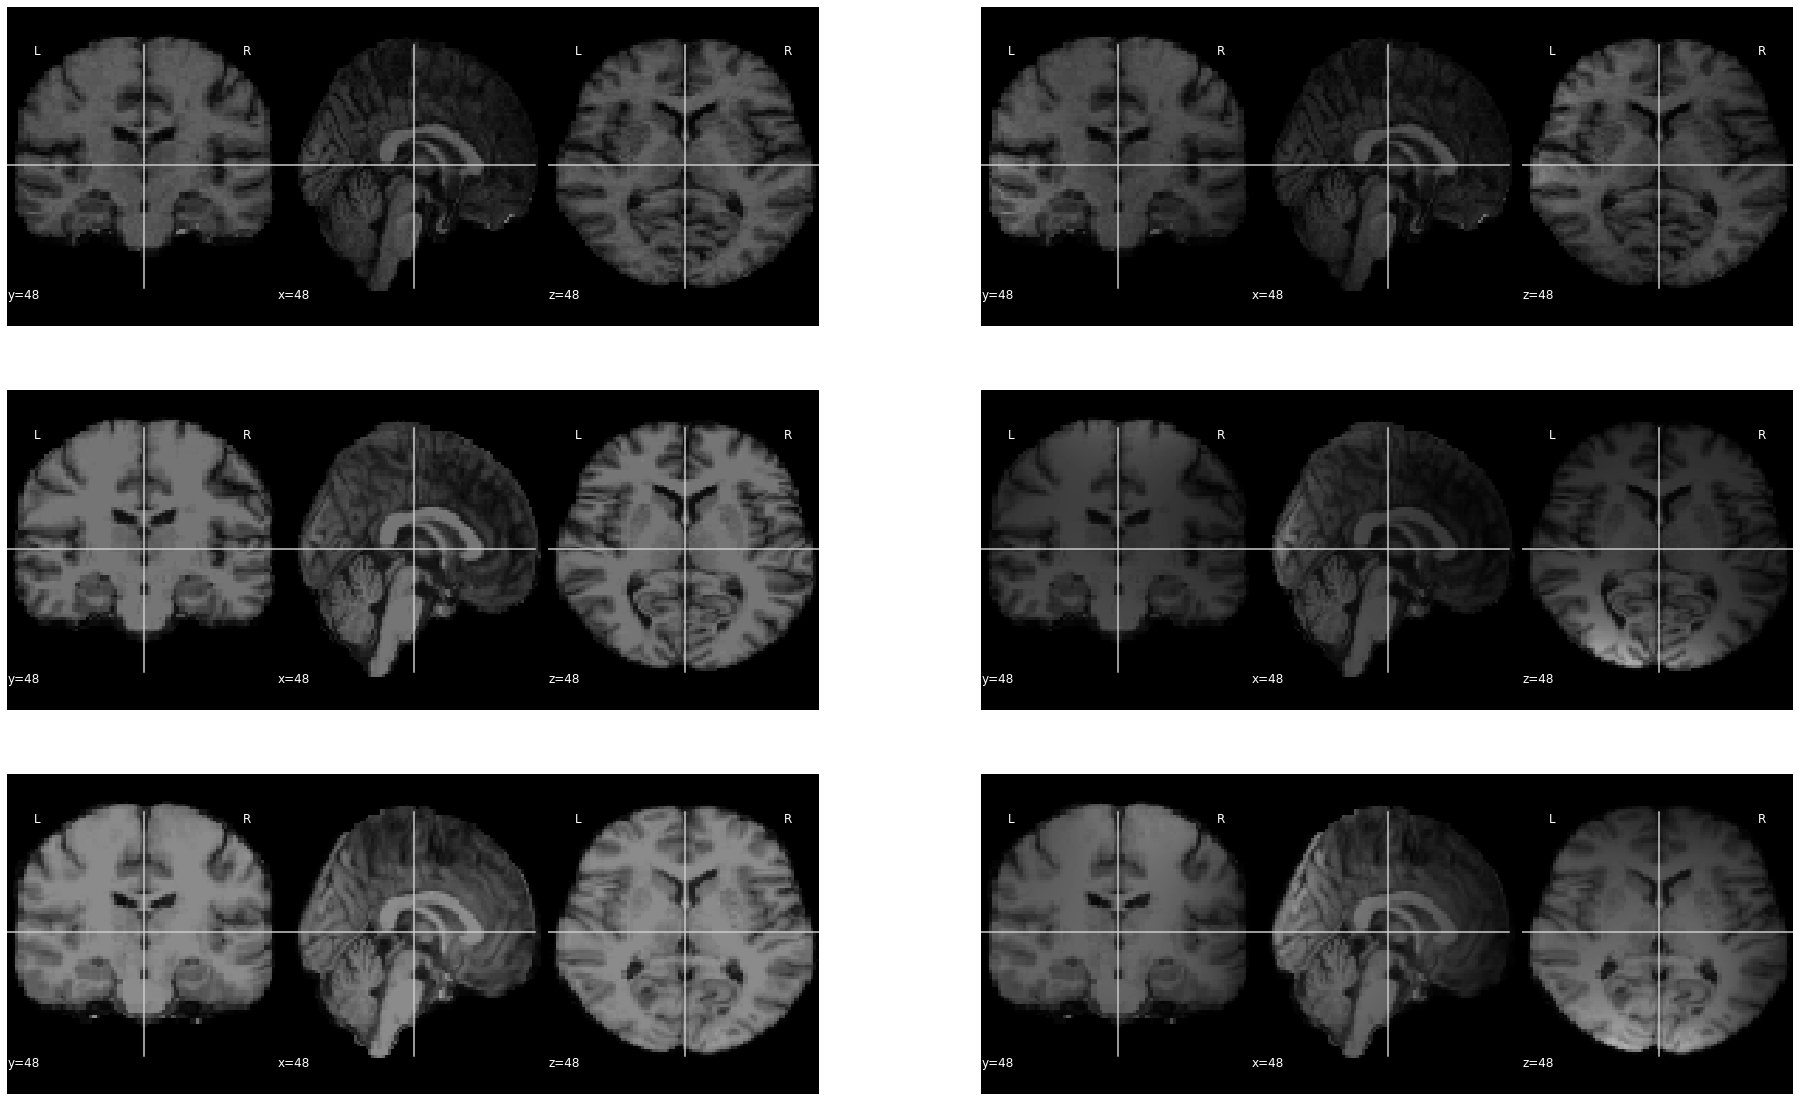

In [71]:
t = "bias"
plot_transformation(transform_dict[t], t)

Transformation: Blur


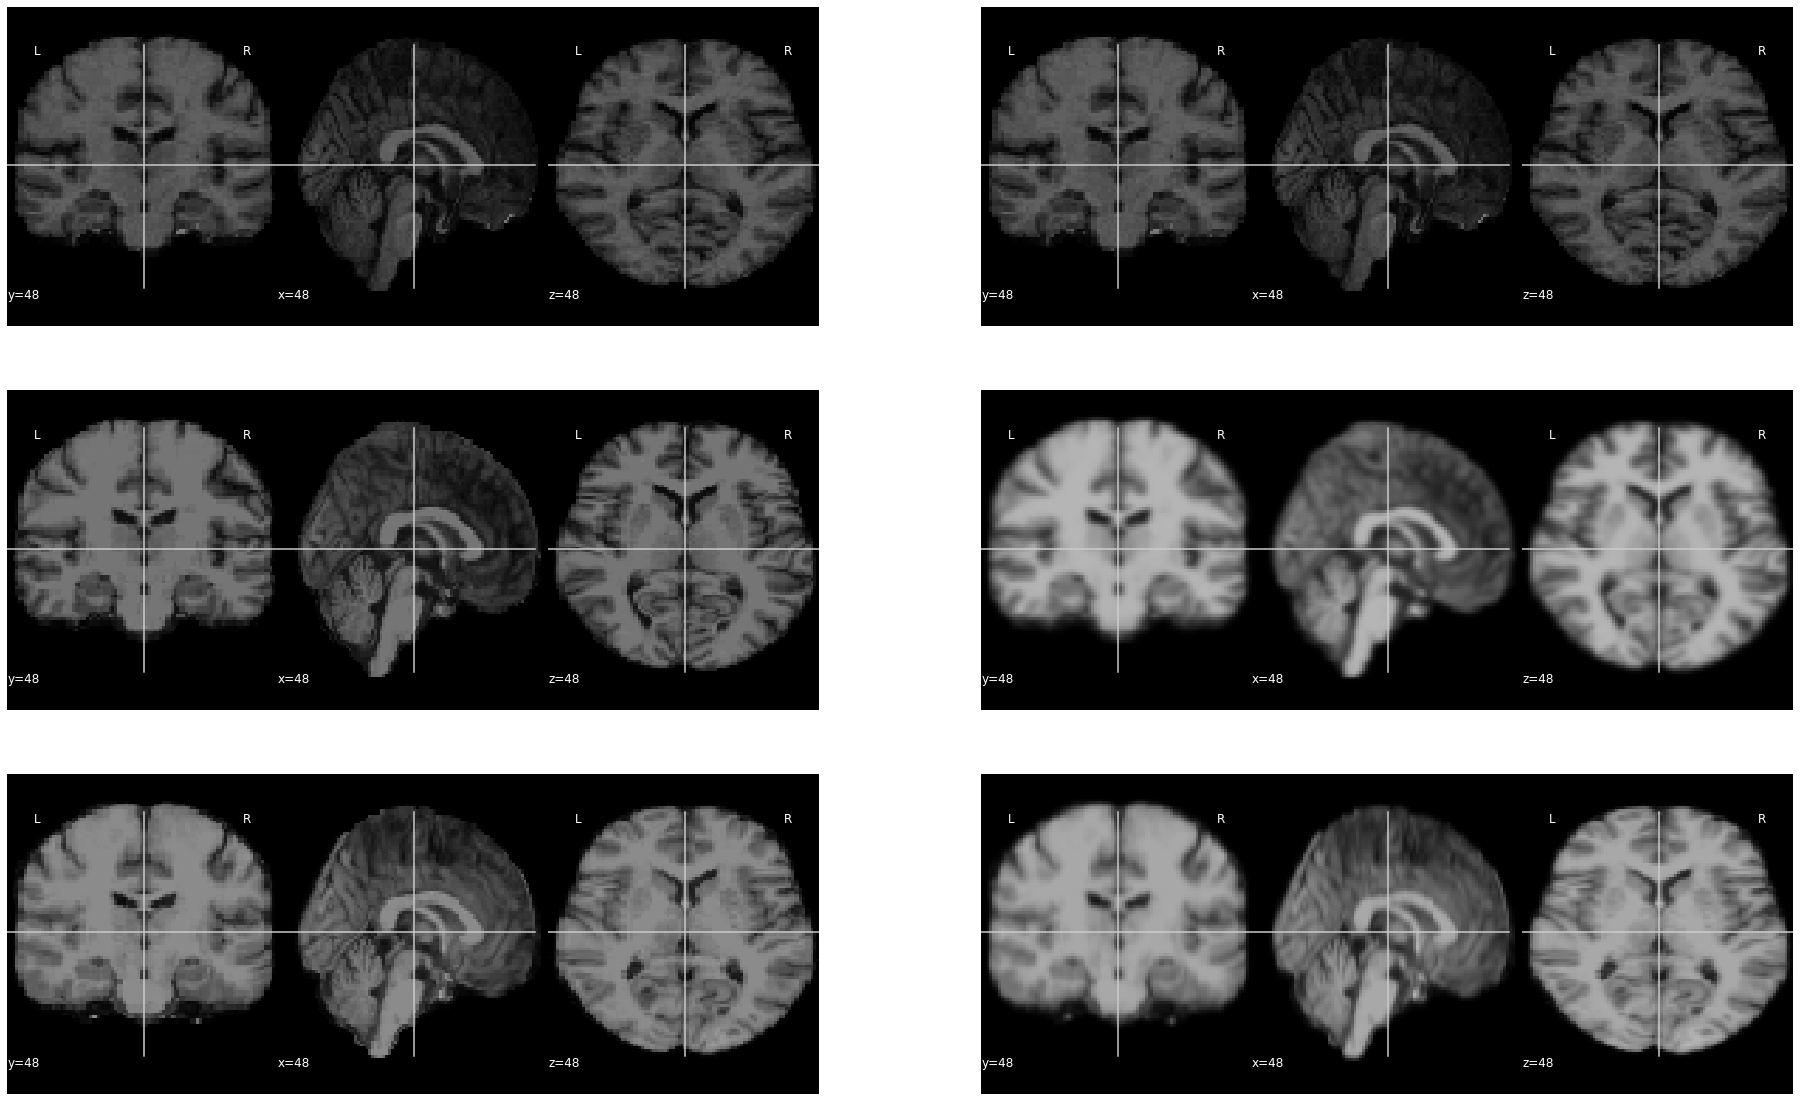

In [72]:
t = "blur"
plot_transformation(transform_dict[t], t)

Transformation: Compose 1


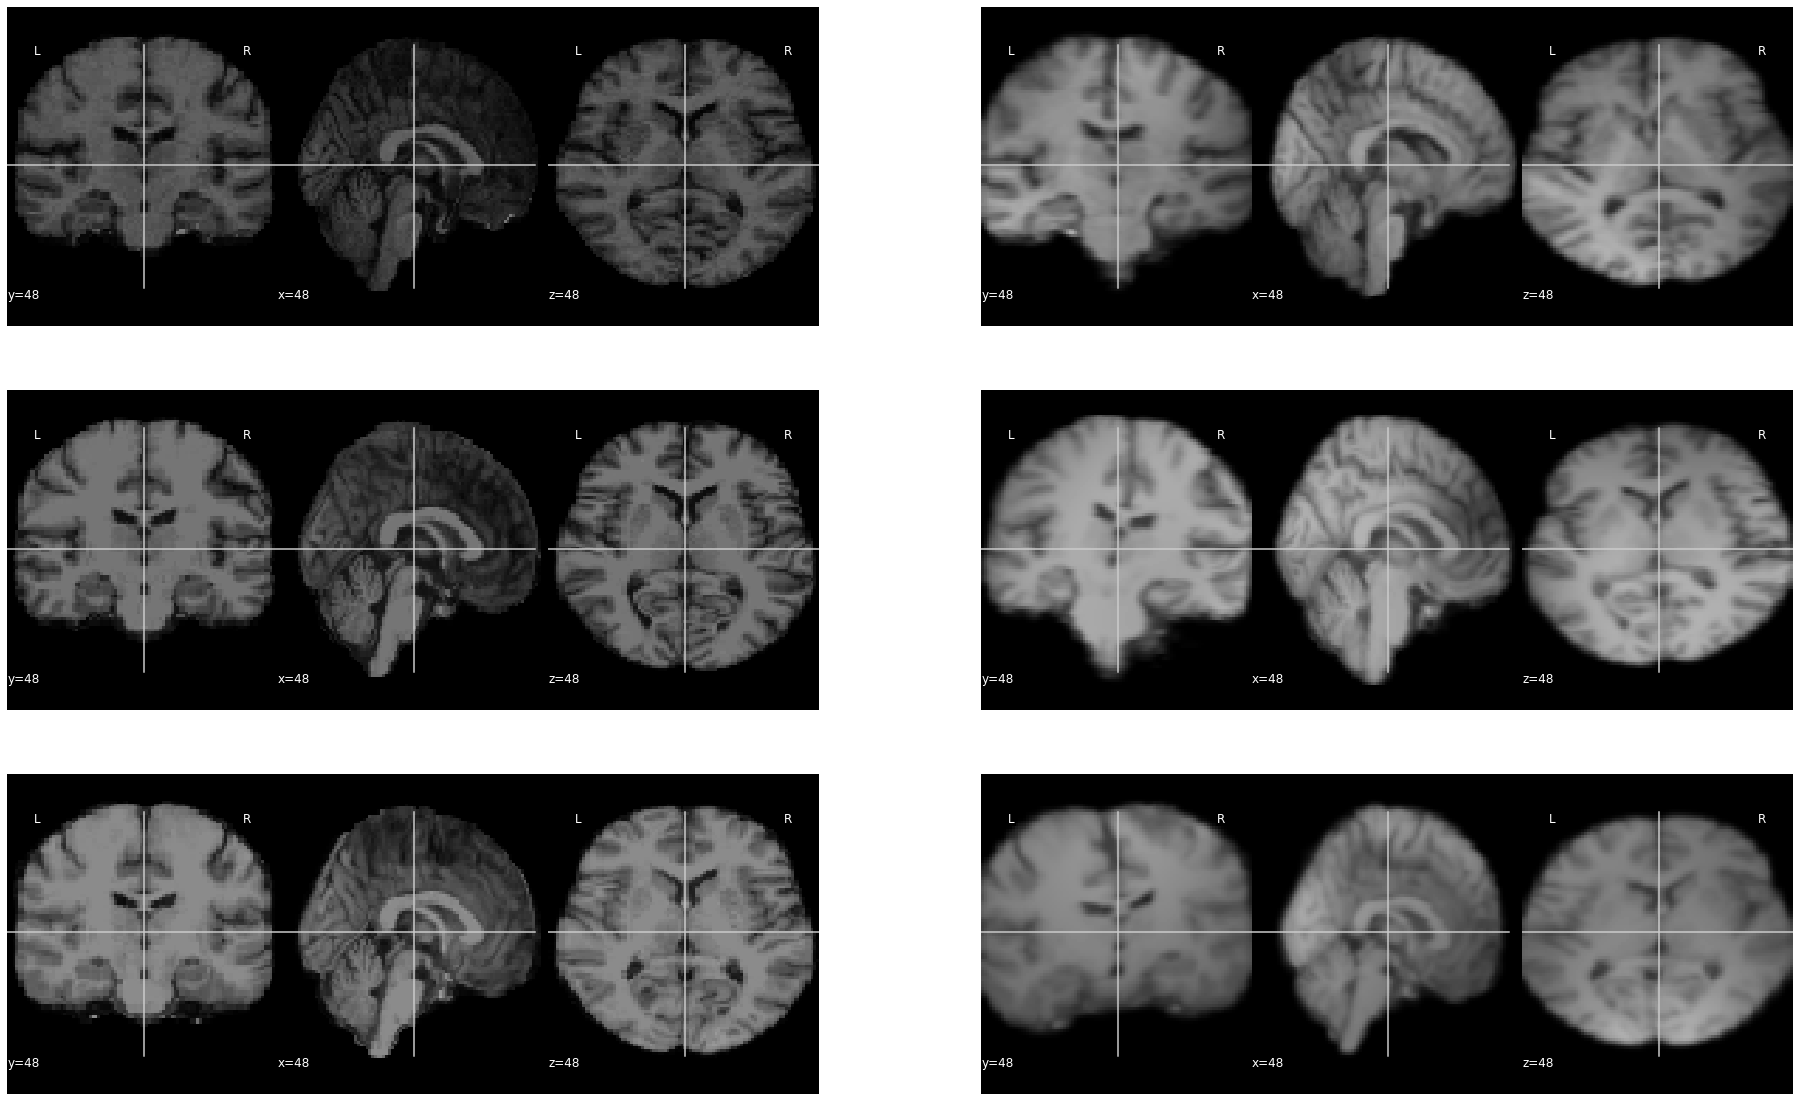

In [76]:
_transform = tio.Compose(
    {
        tio.RandomFlip(axes=["left-right"]),
        tio.RandomAffine(),
        tio.RandomElasticDeformation(),
        tio.RandomGamma((-0.5, 0.5)),
        tio.RandomBiasField(0.3),
        tio.RandomBlur((0, 1)),
    }
)

plot_transformation(_transform, "Compose 1")

Transformation: Compose 2


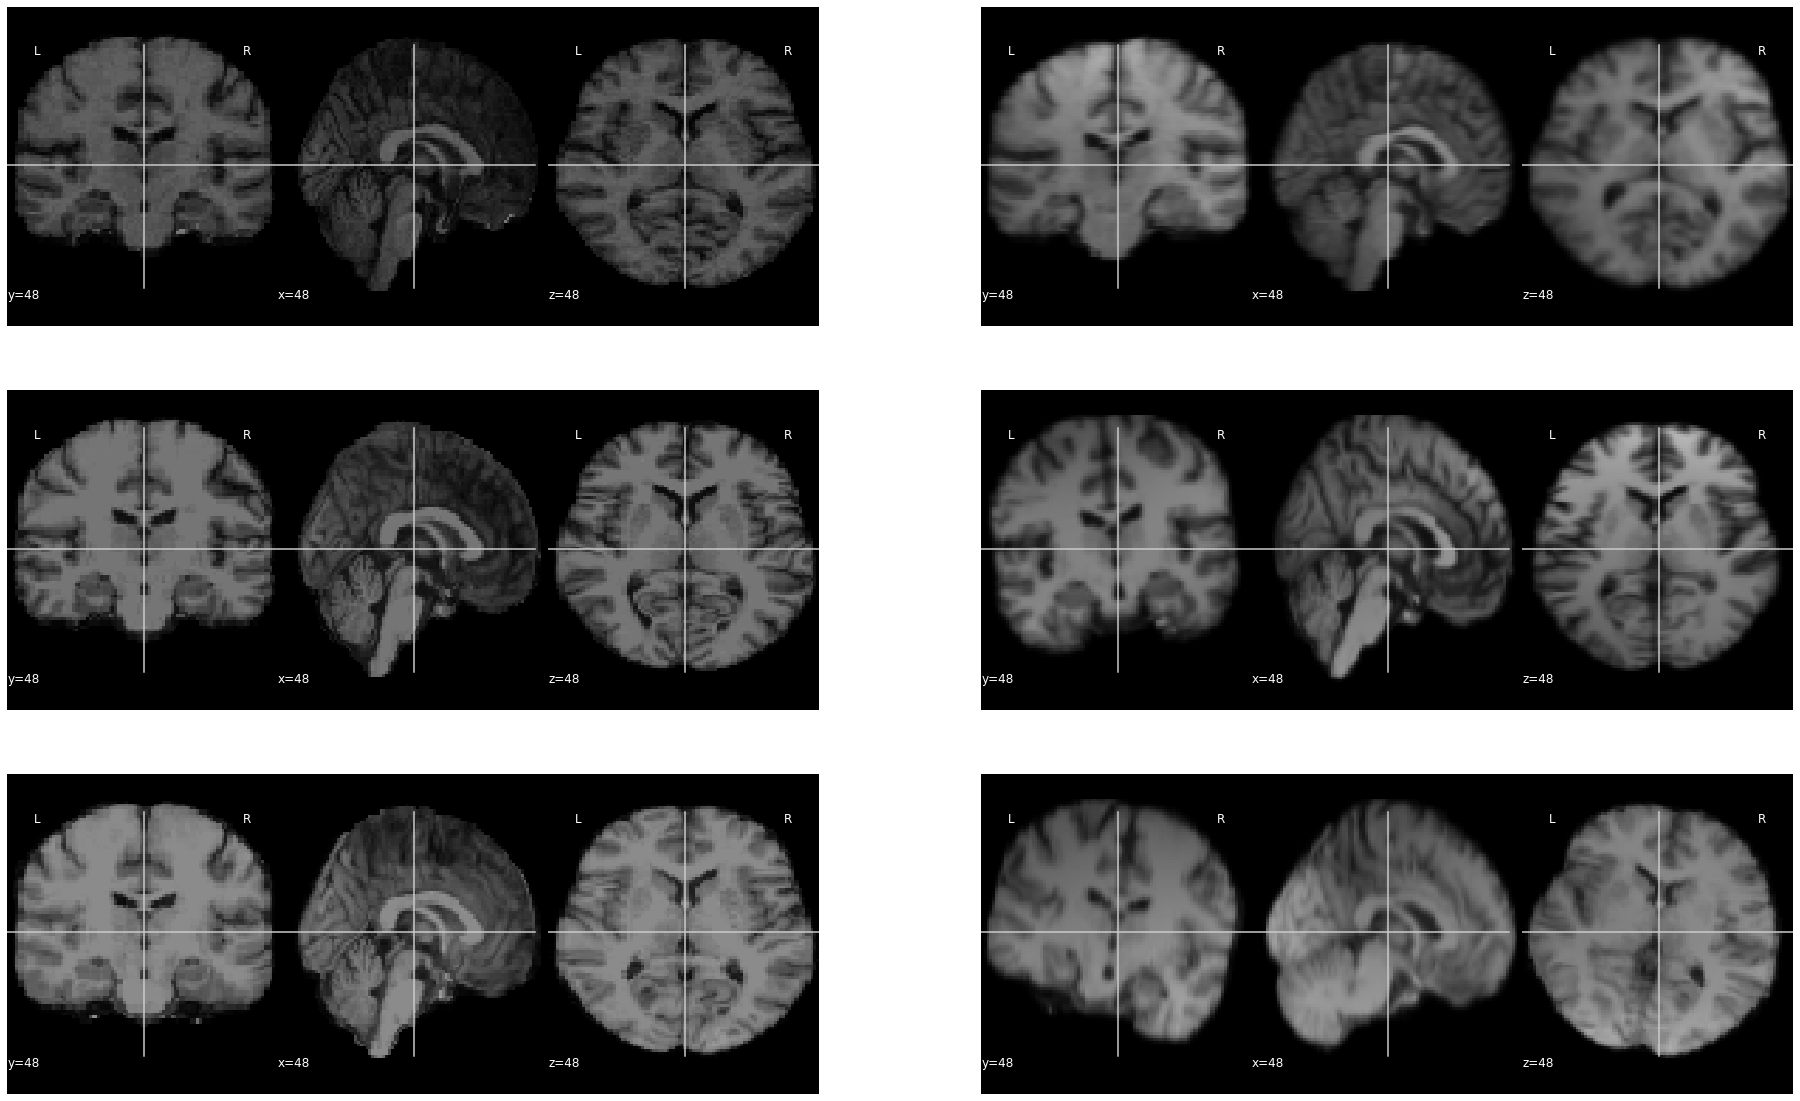

In [77]:
_transform = tio.Compose(
    {
        tio.RandomFlip(axes=["left-right"]),
        tio.OneOf(
            {
                tio.RandomAffine(),
                tio.RandomElasticDeformation(),
            }
        ),
        tio.RandomGamma((-0.5, 0.5)),
        tio.RandomBiasField(0.3),
        tio.RandomBlur((0, 1)),
    }
)

plot_transformation(_transform, "Compose 2")

Transformation: Compose 3


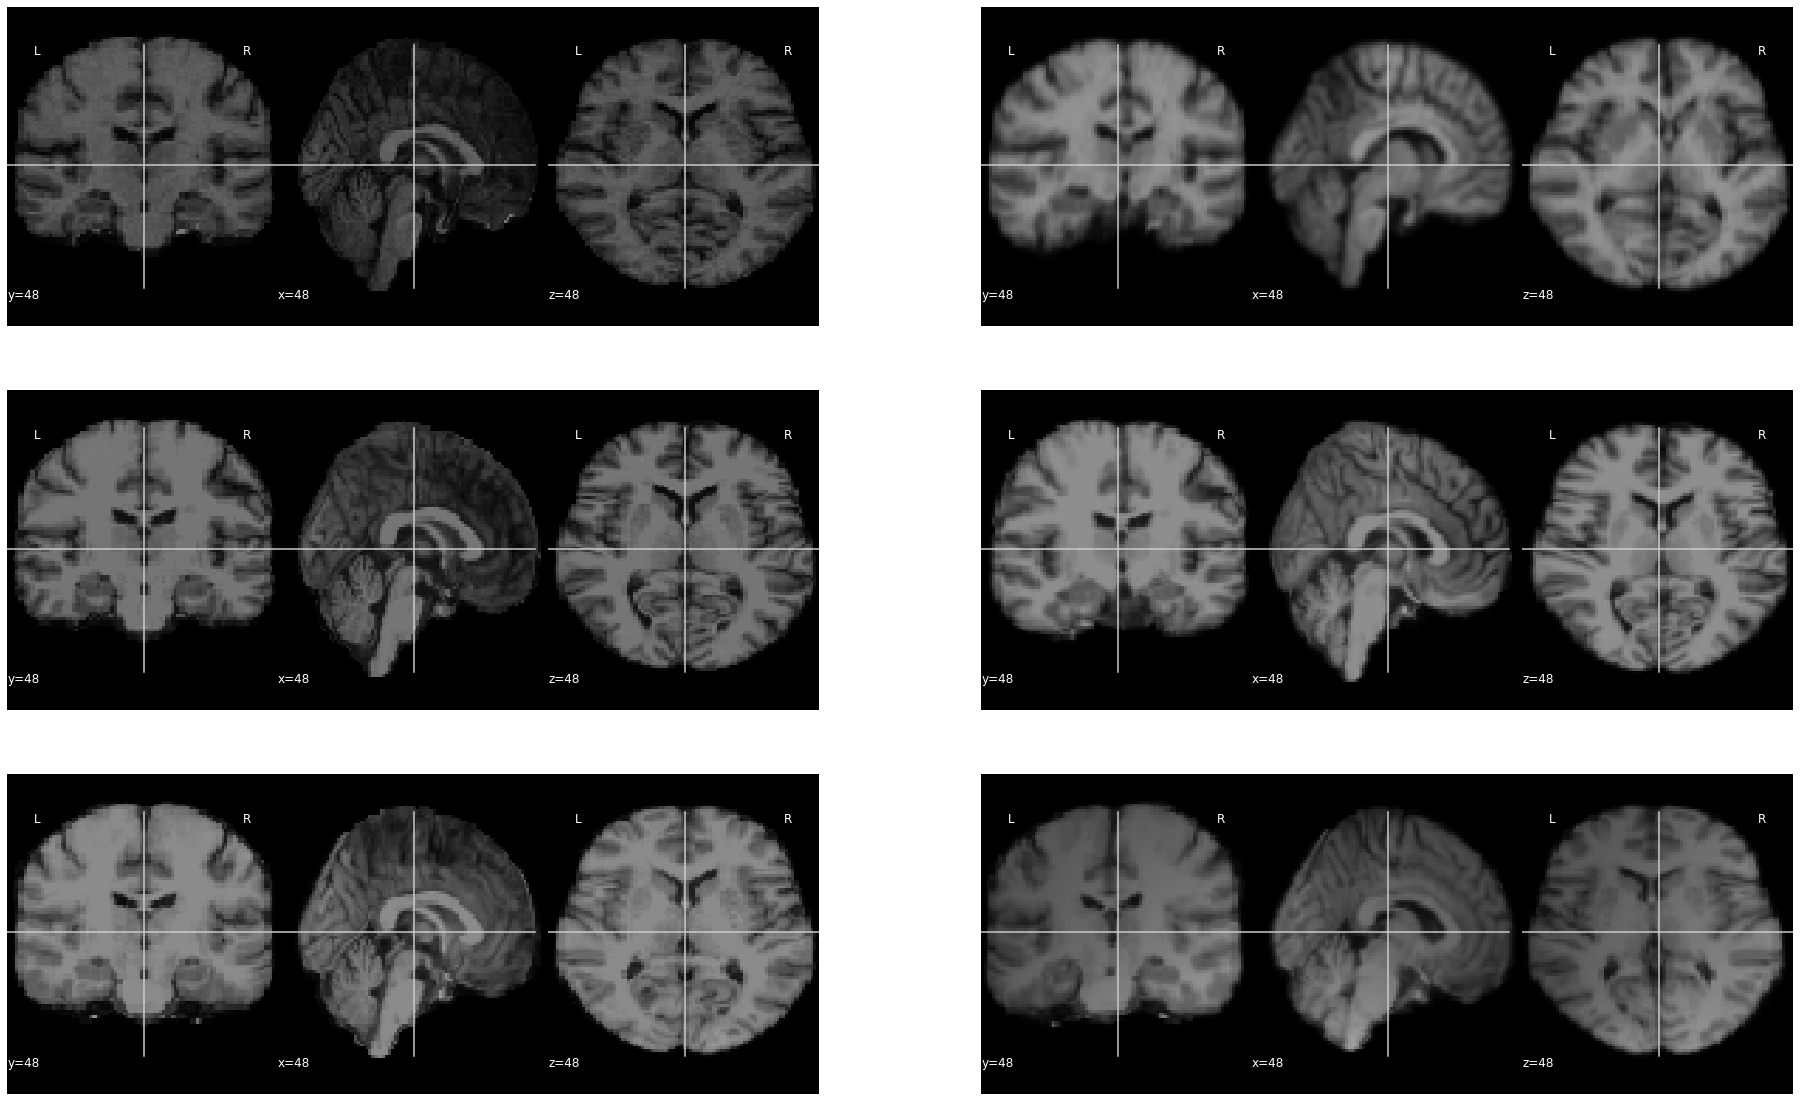

In [78]:
_transform = tio.Compose(
    {
        tio.RandomFlip(axes=["left-right"]),
        tio.OneOf(
            {
                tio.RandomAffine(),
                tio.RandomElasticDeformation(),
            }
        ),
        tio.OneOf(
            {
                tio.RandomGamma((-0.5, 0.5)),
                tio.RandomBiasField(0.3),
                tio.RandomBlur((0, 1)),
            }
        ),
    }
)

plot_transformation(_transform, "Compose 3")